In [1]:
# encoding: utf-8 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from datetime import datetime

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import types as T
from pyspark.sql import functions as F

# create SparkContext and SparkSession to process files
sc = SparkContext('local[2]', 'example')
spark = SparkSession(sc)

In [2]:
%matplotlib notebook

In [3]:
caminho = '../data/antigo/csv/'

In [4]:
pessoal = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_pessoal.csv')
pessoal.createOrReplaceTempView("tab_pessoal")

In [5]:
pessoal.toPandas()

,Address,DateOfBirth,DriversLicence,Emails,FirstName,GenderCode,GenderCodeDescription,HomePhones,LastName,MaritalStatusCode,MaritalStatusCodeDescription,MobilePhones,NationalityCode,NationalityCodeDescription,SocialMedia,Title,id
0,None,1975-11-06,None,None,None,0,Not known,None,None,None,None,None,None,None,None,None,cv12714.xml
1,None,None,None,None,Joel,1,Male,None,Ferreira Amorim,None,None,None,BR,Brazilian,None,None,cv24026.xml
2,None,None,None,None,None,0,Not known,None,None,None,None,None,None,None,None,None,cv32557.xml
3,None,None,None,None,Renan,1,Male,None,Mesquita Nunes,None,None,None,BR,Brazilian,None,None,cv11045.xml
4,None,None,None,None,Fabiano,1,Male,None,Vieira,None,None,None,None,None,None,None,cv2166.xml
5,None,None,None,None,None,0,Not known,None,None,None,None,None,None,None,None,None,cv3875.xml
6,None,None,B,None,Francisco,1,Male,None,T. Silva,None,None,None,None,None,None,None,cv20771.xml
7,None,None,None,None,Gabriel,1,Male,None,Silva,None,None,None,None,None,None,None,cv17433.xml
8,None,None,None,None,Fabio,1,Male,None,Dias Da Silva,None,None,None,BR,Brazilian,None,None,cv19518.xml
9,None,1994-06-12,None,None,Miria,2,Female,None,Pereira Da Silva,None,None,None,None,None,None,None,cv17629.xml


In [6]:
pessoal.describe().toPandas()

,summary,Address,DateOfBirth,DriversLicence,Emails,FirstName,GenderCode,GenderCodeDescription,HomePhones,LastName,MaritalStatusCode,MaritalStatusCodeDescription,MobilePhones,NationalityCode,NationalityCodeDescription,SocialMedia,Title,id
0,count,0,4698,1379,0,17075,20130,20130,0,16989,7,7,0,6411,6411,0,37,20130
1,mean,None,None,8.277691727142857E8,None,None,0.8810730253353204,None,None,None,2.2857142857142856,None,None,None,None,None,None,None
2,stddev,None,None,2.1900713708809633E9,None,None,0.7006412406342762,None,None,None,1.2535663410560172,None,None,None,None,None,None,None
3,min,None,1944-04-21,"""""",None,Abbas,0,Female,None,A. Da Costa Filho Roseli Santos Miranda,1,Divorced,None,AO,American,None,JR,cv10001.xml
4,max,None,2000-03-10,|,None,文件夹内有大量真实数据,2,Not known,None,随着,5,Unmarried,None,YU,Yemeni,None,Sr.,cv9996.xml


<IPython.core.display.Javascript object>


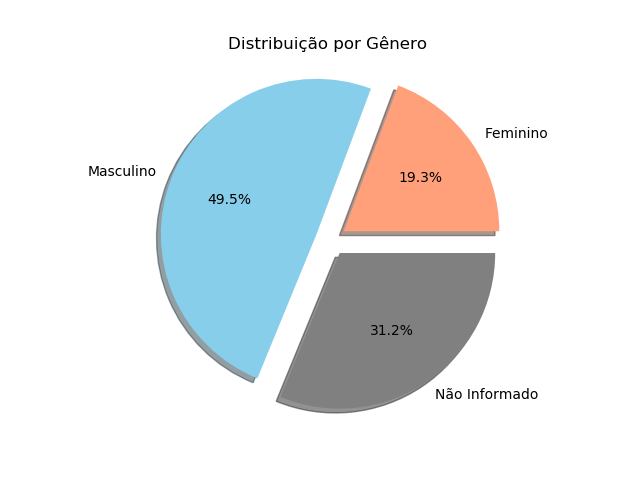

In [7]:
# pizza gendercode
por_genero = spark.sql("""
    select genero
         , count(*) as quantidade
    from (
            select case 
                      when gendercodedescription = 'Male' then 'Masculino'
                      when gendercodedescription = 'Female' then 'Feminino'
                      else 'Não Informado'
                   end as genero
            from tab_pessoal 
         )
    group by genero
    order by genero
""").toPandas()

rotulos = por_genero['genero'].tolist()
quantidades = por_genero['quantidade'].tolist()
explode = [.1] * len(quantidades)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.1f%%',
        shadow=True, startangle=0, wedgeprops={'linewidth': 1}, colors=['lightsalmon', 'skyblue', 'gray'])
ax.set_title(u'Distribuição por Gênero')
ax.axis('equal')

plt.show()

<IPython.core.display.Javascript object>


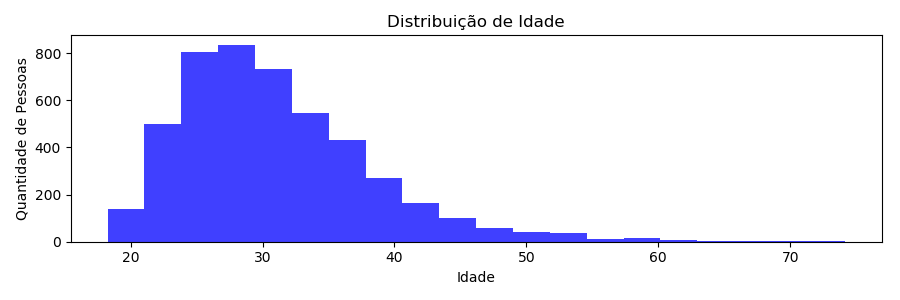

In [8]:
# histograma dateofbirth
anos = spark.sql("""
    select datediff('2018-06-07', cast(dateofbirth as date)) / float(365.25) as data
    from tab_pessoal
    where dateofbirth is not null
""").toPandas()['data'].tolist()

fig, ax = plt.subplots(figsize=(9, 3))

ax.hist(anos, 20, histtype='stepfilled', facecolor='b', alpha=0.75)
ax.set_title(u'Distribuição de Idade')
ax.set_xlabel(u'Idade')
ax.set_ylabel(u'Quantidade de Pessoas')

fig.tight_layout()
plt.show();

In [9]:
computacao = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_computacao.csv')
computacao.createOrReplaceTempView("tab_computacao")

In [10]:
computacao.toPandas()

,ComputerSkillDuration,ComputerSkillName,id
0,None,Estratégico,cv12714.xml
1,None,PMBOK,cv12714.xml
2,None,BPM,cv12714.xml
3,7,RUP,cv12714.xml
4,0,Visio,cv12714.xml
5,None,MS-Project,cv12714.xml
6,None,MS-Office,cv12714.xml
7,1,ITIL,cv12714.xml
8,None,SVN,cv12714.xml
9,None,SCRUM,cv12714.xml


In [11]:
computacao.describe().toPandas()

,summary,ComputerSkillDuration,ComputerSkillName,id
0,count,108972,309695,311983
1,mean,2.922833388393349,4.904761904761905,None
2,stddev,3.1477871276563065,7.306878690006848,None
3,min,0,! DB2,cv10001.xml
4,max,9,韀,cv9996.xml


In [12]:
# quantidade de pessoas com conhecimento
spark.sql("""
    select count(*) from (select distinct id from tab_computacao)    
""").collect()[0][0] * 100 / float(997)

2019.0571715145436

In [13]:
# media de conhecimentos de computacao por pessoa
spark.sql("""
    select round(avg(quantidade)) as media 
    from (select id
               , count(*) as quantidade
          from (select id
                     , computerskillname 
                from tab_computacao 
                where computerskillname is not null)
          group by id)
""").collect()[0][0]

17.0

In [14]:
# media de duracao da habilidade de computacao
spark.sql("""
    select round(avg(media)) as tempo
    from (select id
               , round(avg(computerskillduration)) as media
          from tab_computacao 
          where computerskillduration > 0
          group by id)
""").collect()[0][0]

3.0

In [15]:
educacao = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_educacao.csv')
educacao.createOrReplaceTempView("tab_educacao")

In [16]:
educacao.toPandas()

,DegreeDirection,DiplomaCode,DiplomaCodeDescription,EducationLevelCode,EducationLevelCodeDescription,EndDate,GradePointAverage,InstituteName,StartDate,id
0,MBA em Gestão de Sistemas de Informação,4,Unknown,4,Bachelor,2004-06-30,None,Universidade Católica de Brasília - UCB,None,cv12714.xml
1,Administração de Empresas,4,Unknown,7,Course,2000-06-30,None,Universidade de Brasília - UnB,None,cv12714.xml
2,Processamento de Dados,4,Unknown,7,Course,1996-06-30,None,União Educacional de Brasília - UNEB,None,cv12714.xml
3,Gerência de Processos de Negócio - BPM (2011BR...,4,Unknown,7,Course,2011-12-31,None,CBPP; 174658,None,cv12714.xml
4,Implantando e Operando Escritórios de Projeto,4,Unknown,7,Course,2015-11-30,None,PMO),None,cv12714.xml
5,Contratação de bens e serviços de TI (IN04 e J...,4,Unknown,7,Course,2015-10-31,None,Brasília,None,cv12714.xml
6,Monitoramento e Avaliação de Indicadores de De...,4,Unknown,7,Course,2015-05-31,None,Brasília,None,cv12714.xml
7,CPRE; FL Certified Professional for Requiremen...,4,Unknown,7,Course,None,None,Brasília,None,cv12714.xml
8,Workshop Project Model Canvas,4,Unknown,None,None,2014-06-30,None,Brasília,None,cv12714.xml
9,13º Encontro de Gerenciamento de Projetos,4,Unknown,None,None,2013-06-30,None,DF,None,cv12714.xml


In [17]:
educacao.describe().toPandas()

,summary,DegreeDirection,DiplomaCode,DiplomaCodeDescription,EducationLevelCode,EducationLevelCodeDescription,EndDate,GradePointAverage,InstituteName,StartDate,id
0,count,102026,104067,104067,103613,103613,45049,0,68784,9821,107087
1,mean,6.929487357142857E7,3.9463614786627845,None,6.281287097178925,None,None,None,7.24079250885802E8,None,None
2,stddev,2.592728047916504E8,0.39737320199977766,None,1.3890558647337141,None,None,None,8.190461157966871E9,None,None
3,min,! Lógica de Programação,1,Unknown,1,Associate Degree,1931-02-28,None,!,1930-03-31,cv10001.xml
4,max,; ­ Delphi 7.0; ; ­ Linux Avançado; ; ­ Java B...,4,no,8,Vocational Education,actualidad,None,; ­ ARIS ­DBA­; IBM / Rational (SP­; DBA ­; Pe...,2019-09-01,cv9996.xml


In [18]:
por_nivel = spark.sql("""
    select nivel, count(*) as quantidade from (
    select case 
              when lcase(educationlevelcodedescription) = 'bachelor' then 'curso superior'
              when lcase(educationlevelcodedescription) = 'vocational education' then 'outros'
              when lcase(educationlevelcodedescription) = 'secondary education' then 'ensino médio'
              when lcase(educationlevelcodedescription) = 'master' then 'pós-graduação'
              when lcase(educationlevelcodedescription) = 'university' then 'curso superior'
              when lcase(educationlevelcodedescription) = 'post-master' then 'pós-graduação'
              when lcase(educationlevelcodedescription) = 'course' then 'curso'
              when lcase(educationlevelcodedescription) is null then 'não informado'
           end as nivel
    from tab_educacao 
    -- where educationlevelcodedescription is not null
    )
    group by nivel
    order by nivel
""").toPandas()
por_nivel

,nivel,quantidade
0,None,1
1,curso,79105
2,curso superior,15708
3,ensino médio,2130
4,não informado,3474
5,outros,358
6,pós-graduação,6311


<IPython.core.display.Javascript object>


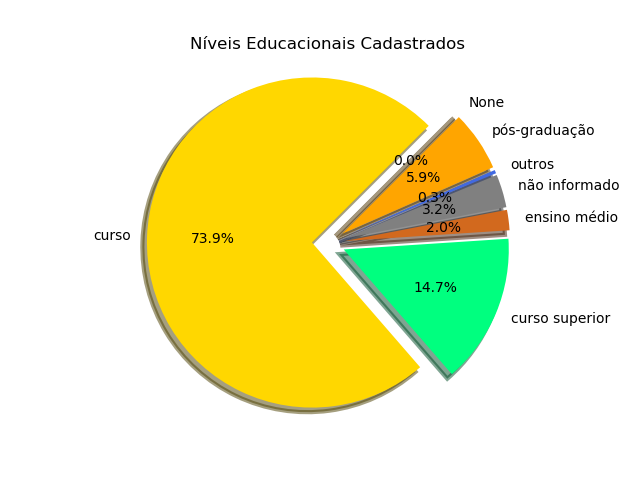

In [19]:
# pizza educationlevelcodedescription
rotulos = por_nivel['nivel'].tolist()
quantidades = por_nivel['quantidade'].tolist()
explode = [.1] * len(por_nivel)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.1f%%',
        shadow=True, startangle=45, wedgeprops={'linewidth': 3}, colors=['orange', 'gold', 'springgreen',  'chocolate', 'grey','royalblue'])
ax.set_title(u'Níveis Educacionais Cadastrados')
ax.axis('equal')

plt.show();

In [20]:
emprego = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_emprego.csv')
emprego.createOrReplaceTempView("tab_emprego")

In [21]:
emprego.toPandas()

,Description,EmployerName,EndDate,ExperienceYears,JobTitle,StartDate,id
0,Principais Atividades Desenvolvidas: Gerenciam...,Empresa FNDE - Fundo Nacional de Desenvolvimen...,actualidad,2,Sistema de Prestação de Contas do FNDE,2014-12-01,cv12714.xml
1,Principais Atividades Desenvolvidas: Acompanha...,"INTRASICONV, SAPE, SIOPE, Cartão PDDE",2014-12-01,2,Gerente de Operações,2013-03-01,cv12714.xml
2,Principais Atividades Desenvolvidas: Acompanha...,Caixa Seguros - Empresa do Segmento de Seguros,2013-02-28,1,Gerente de Projetos,2012-06-01,cv12714.xml
3,"- ICMBio, Sistemas de gerenciamento de serviço...",Projetos Instituto Chico Mendes de Biodiversidade,2012-05-31,1,Gerente de Projetos,2011-09-01,cv12714.xml
4,: Diversos projetos do Instituto Chico Mendes ...,Confidere IT - Empresa do Segmento de Informática,2011-08-31,1,Projetos,2011-02-01,cv12714.xml
5,: Diversos projetos de gestão na área de saúde...,MIRANTE S/A,2011-01-31,1,Projetos,2009-09-01,cv12714.xml
6,Reporte: Gerente da fábrica de software: Princ...,Stefanini S/A,2009-08-31,0,Analista de Requisitos,2009-05-01,cv12714.xml
7,None,INEP/PNUD - Empresa do Segmento do Governo,None,None,Censo,None,cv12714.xml
8,Principais Atividades Desenvolvidas: Mapeament...,INEP/PNUD - Empresa do Segmento do Governo,2009-04-30,1,Gerente de Projeto,2008-10-01,cv12714.xml
9,Principais Atividades Desenvolvidas: Participa...,OSM Informática - Empresa do Segmento de Infor...,2008-09-30,1,Analista de processos,2008-04-01,cv12714.xml


In [22]:
emprego.describe().toPandas()

,summary,Description,EmployerName,EndDate,ExperienceYears,JobTitle,StartDate,id
0,count,78727,93847,70549,85975,82467,85734,99646
1,mean,5265254.75,1720.142857142857,None,2.096137069476917,3.3333333333333335,3.5,None
2,stddev,1.0530496833335241E7,3728.1899284850206,None,2.421887581418449,3.214550253664318,3.5355339059327378,None
3,min,""""""" Coordenação de projetos de pesquisa, aná...",MOBILE / iOS / Android / UI & UX Designers / ...,' Help_Desk = troca de maquinas e manutenção ...,INFRASTRUCTURE,Global locations: Austin,Baar,Bangalore
4,max,"· Gestão de Projetos, levantamento de escopo, ...",૩ RHCSA ­ Red Hat Certified System Administrator,actualidad,Talent Acquisiton | Business Development & Edu...,૩ Administração da Segurança de Redes de Compu...,Coordenador de Fábrica de Testes de Software,cv9996.xml


In [23]:
# quantidade de startdate com enddate
spark.sql("""
    select count(*)
    from tab_emprego
    where startdate is not null
      and enddate is not null
""").collect()[0][0] * 100 / float(emprego.count())

70.55677096923108

In [24]:
# media de mudancas de emprego
spark.sql("""
    select round(avg(quantidade)) as media
         , min(quantidade) as minimo
         , max(quantidade) as maximo
    from (
            select id
                 , count(*) as quantidade
            from (
                    select id
                         , employername
                         , count(*) as quantidade
                    from tab_emprego
                    group by id
                           , employername
                 )
            group by id
         )
""").toPandas()  #.collect()[0][0]

,media,minimo,maximo
0,4.0,1,53


In [25]:
# media de promocoes
spark.sql("""
            select round(avg(quantidade_cargos - 1)) as media
                 , min(quantidade_cargos - 1) as minimo
                 , max(quantidade_cargos - 1) as maximo
            from (
                    select id
                         , employername
                         , count(*) as quantidade_cargos
                    from tab_emprego
                    group by id
                           , employername
                 )
            where quantidade_cargos > 1
            
""").toPandas()

,media,minimo,maximo
0,1.0,1,22


In [26]:
# media dos anos de experiencia
spark.sql("""
    select round(avg(anos)) from (
    select id, avg(experienceyears) as anos
    from tab_emprego
    group by id)
""").collect()[0][0]

2.0

In [27]:
idioma = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_idioma.csv')
idioma.createOrReplaceTempView("tab_idioma")

In [28]:
idioma.toPandas()

,LanguageProficiencyCode,LanguageProficiencyCodeDescription,LanguageSkillCode,LanguageSkillCodeDescription,id
0,4,Advanced,BH,Bihari,cv12714.xml
1,3,Intermediate,EU,Basque,cv12714.xml
2,3,Intermediate,EN,English,cv12714.xml
3,None,None,None,None,cv24026.xml
4,None,None,None,None,cv32557.xml
5,None,None,EN,English,cv11045.xml
6,None,None,FR,French,cv11045.xml
7,3,Intermediate,EN,English,cv2166.xml
8,None,None,ES,Spanish,cv2166.xml
9,2,Basic Knowledge,ES,Spanish,cv3875.xml


In [29]:
idioma.describe().toPandas()

,summary,LanguageProficiencyCode,LanguageProficiencyCodeDescription,LanguageSkillCode,LanguageSkillCodeDescription,id
0,count,11535,11535,15016,15015,25267
1,mean,3.41309059384482,None,None,None,None
2,stddev,1.228830567623791,None,None,None,None
3,min,1,Advanced,AA,Afar,cv10001.xml
4,max,6,No,ZH,japanese,cv9996.xml


In [30]:
# quantidade de pessoas
spark.sql("""
    select count(*) from (
    select distinct id
    from tab_idioma
    where languageskillcode is not null)
""").collect()[0][0] * 100 / float(997)

998.4954864593782

In [31]:
por_idioma = spark.sql("""
    select idioma
         , count(*) as quantidade 
    from (   select case 
                       when lcase(languageskillcodedescription) = 'english' then 'inglês'
                       when lcase(languageskillcodedescription) = 'spanish' then 'espanhol' 
                       when lcase(languageskillcodedescription) = 'portuguese' then 'português' 
                       when lcase(languageskillcodedescription) is null then 'não informado'
                       else 'outros'
                    end as idioma
             from tab_idioma
             -- where languageskillcodedescription is not null
             --  and lcase(languageskillcodedescription) != 'portuguese'    
               )
    group by idioma
""").toPandas()
por_idioma

,idioma,quantidade
0,português,1507
1,inglês,9498
2,espanhol,3071
3,não informado,10252
4,outros,939


<IPython.core.display.Javascript object>


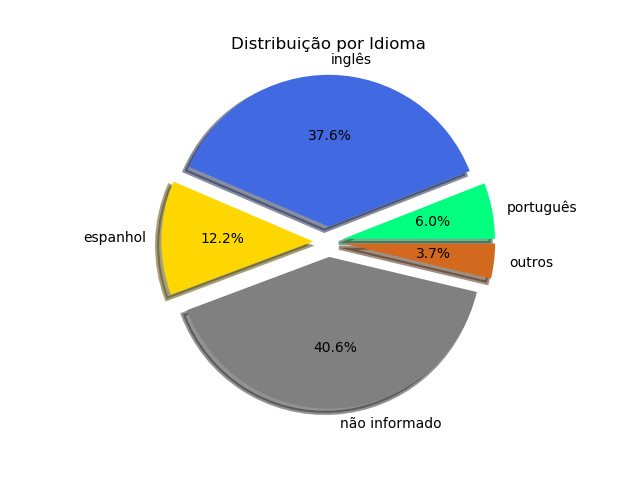

In [32]:
# pizza idiomas
rotulos = por_idioma['idioma'].tolist()
quantidades = por_idioma['quantidade'].tolist()
explode = [.1] * len(por_idioma)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.1f%%',
        shadow=True, startangle=0, wedgeprops={'linewidth': 3}, colors=['springgreen', 'royalblue', 'gold', 'grey', 'chocolate'])
ax.set_title(u'Distribuição por Idioma')
ax.axis('equal')

plt.show();

In [33]:
# proficiencia ingles
ingles = spark.sql("""
    select proficiencia
         , count(*) as quantidade
    from (
            select case 
                      when lcase(languageproficiencycodedescription) = 'basic knowledge' then 'básico'
                      when lcase(languageproficiencycodedescription) = 'intermediate' then 'intermediário'
                      when lcase(languageproficiencycodedescription) = 'advanced' then 'avançado'
                      when lcase(languageproficiencycodedescription) = 'near native' then 'nativo'
                      when lcase(languageproficiencycodedescription) is null then 'não informado'
                   end as proficiencia
            from tab_idioma
            where lcase(languageskillcodedescription) = 'english'
              --and languageproficiencycodedescription is not null
          )
    group by proficiencia
""").toPandas()
ingles

,proficiencia,quantidade
0,intermediário,3239
1,avançado,1895
2,None,39
3,básico,1465
4,nativo,549
5,não informado,2311


<IPython.core.display.Javascript object>


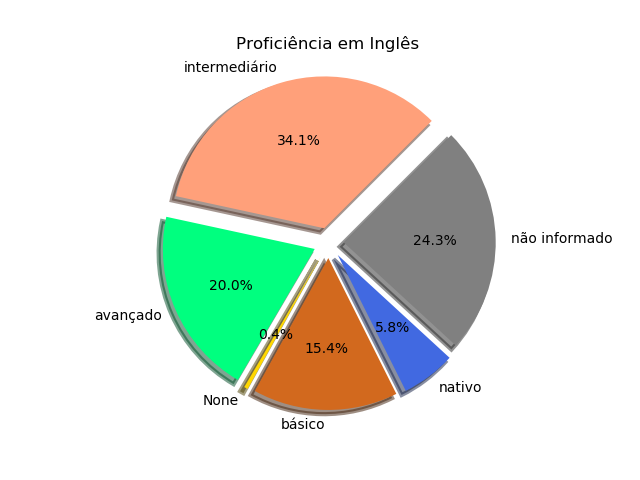

In [34]:
# pizza proficiencia em ingles
rotulos = ingles['proficiencia'].tolist()
quantidades = ingles['quantidade'].tolist()
explode = [.1] * len(ingles)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.1f%%',
        shadow=True, startangle=45, wedgeprops={'linewidth': 3}, colors=['lightsalmon', 'springgreen', 'gold', 'chocolate', 'royalblue', 'grey'])
ax.set_title(u'Proficiência em Inglês')
ax.axis('equal')

plt.show();

In [35]:
outros = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_outros.csv')
outros.createOrReplaceTempView("tab_outros")

In [36]:
outros.toPandas()

,AvailabilityCode,AvailabilityCodeDescription,CVComment,CVTitle,CandidatePermission,CandidateStatusCode,CandidateStatusCodeDescription,CurrentEmployer,CurrentJob,ExternalID,ExtraInfo,HighestEducationLevelCode,HighestEducationLevelCodeDescription,Last3Experiences,ProfilePicture,SalaryCode,SalaryCodeDescription,TotalExperienceYears,id
0,None,None,None,None,None,None,None,Empresa FNDE - Fundo Nacional de Desenvolvimen...,Sistema de Prestação de Contas do FNDE,None,None,4,Bachelor,"Gerente de Operações, Gerente de Projetos, Ger...",None,None,None,14,cv12714.xml
1,None,None,None,None,None,None,None,Secretaria da Educação,Professor de Informática,None,None,4,Bachelor,"Técnico de Teste de Software, Instrutor",None,None,None,4,cv24026.xml
2,None,None,None,None,None,None,None,Experience,Consultor,None,None,None,None,"Consultor, Consultor, Gerente de Projetos",None,None,None,16,cv32557.xml
3,None,None,None,None,None,None,None,BANCORBRÁS PARTICIPAÇÕES E EMPRENDIMENTOS S.A,Estagiário,None,None,None,None,"Diretor de Marketing, Menor Aprendiz",None,None,None,4,cv11045.xml
4,None,None,None,None,None,None,None,POLITEC Ltda,Analista de Sistemas,None,None,4,Bachelor,"Analista de Sistemas Sênior, Analista de Sistemas",None,None,None,9,cv2166.xml
5,None,None,None,None,None,None,None,RSI Informática entrou,Líder de Projetos,None,None,5,Master,"Analista de Sistemas Sênior, Gerente de Config...",None,None,None,8,cv3875.xml
6,None,None,None,None,None,None,None,ALPHA BSB IMÓVEIS LTDA,CHEFE DE TESOURARIA,None,None,4,Bachelor,"Enc. Administrativo e Financeiro/Faturamento, ...",None,None,None,10,cv20771.xml
7,None,None,None,None,None,None,None,Indra Company do Brasil,Gerente de Projetos,None,None,4,Bachelor,"Gerente de Projetos, Diretor Técnico, Analista...",None,None,None,10,cv17433.xml
8,None,None,None,None,0,None,None,UOLDIVEO Datacenter S/A,Gerente de Projetos,None,None,5,Master,"Analista de Projetos, Estagiário",None,None,None,16,cv19518.xml
9,None,None,None,None,0,None,None,CTIS-Tecnologia S.A,TELEOPERADORA_PROJETO CAESB,None,None,4,Bachelor,"ÁREA ADMINISTRATIVA EM ENSINO MÉDIO, TELEOPERA...",None,None,None,3,cv17629.xml


In [37]:
outros.describe().toPandas()

,summary,AvailabilityCode,AvailabilityCodeDescription,CVComment,CVTitle,CandidatePermission,CandidateStatusCode,CandidateStatusCodeDescription,CurrentEmployer,CurrentJob,ExternalID,ExtraInfo,HighestEducationLevelCode,HighestEducationLevelCodeDescription,Last3Experiences,ProfilePicture,SalaryCode,SalaryCodeDescription,TotalExperienceYears,id
0,count,0,0,0,0,7772,0,0,17494,18140,0,0,15283,15283,16620,0,0,0,17233,20130
1,mean,None,None,None,None,0.0,None,None,1.0,7.0,None,None,3.996074069227246,None,None,None,None,None,8.498056055242849,None
2,stddev,None,None,None,None,0.0,None,None,NaN,NaN,None,None,1.0061896012612508,None,None,None,None,None,6.22242377359979,None
3,min,None,None,None,None,0,None,None,"""Caixa Seguradora"""" da Fábrica de Software da ...","""Analista de Sistemas Sênior """"PJ""""""",None,None,1,Associate Degree,"""Administrador do Campus I e II """"Prefeito"""", ...",None,None,None,0,cv10001.xml
4,max,None,None,None,None,0,None,None,"área de Automação, OSX Telecomunicações (Visen...",área administrativa,None,None,7,Vocational Education,"é Especialista Técnico em Testes, Líder Técnic...",None,None,None,9,cv9996.xml


In [38]:
# ultimo grau de instrucao alcancado
instrucao = spark.sql("""
    select instrucao, count(*) as quantidade
    from (
            select case 
                      when lcase(highesteducationlevelcodedescription) = 'bachelor' then 'curso superior'
                      when lcase(highesteducationlevelcodedescription) = 'vocational education' then 'outros'
                      when lcase(highesteducationlevelcodedescription) = 'secondary education' then 'ensino médio'
                      when lcase(highesteducationlevelcodedescription) = 'master' then 'pós-graduação'
                      when lcase(highesteducationlevelcodedescription) = 'university' then 'curso superior'
                      when lcase(highesteducationlevelcodedescription) = 'post-master' then 'pós-graduação'
                      when lcase(highesteducationlevelcodedescription) = 'course' then 'curso'
                      when lcase(highesteducationlevelcodedescription) is null then 'não informado'
                   end as instrucao
            from tab_outros
           -- where highesteducationlevelcodedescription is not null
    )
    group by instrucao
    order by instrucao
""").toPandas()
instrucao

,instrucao,quantidade
0,None,1
1,curso superior,9996
2,ensino médio,1181
3,não informado,4847
4,outros,193
5,pós-graduação,3912


<IPython.core.display.Javascript object>


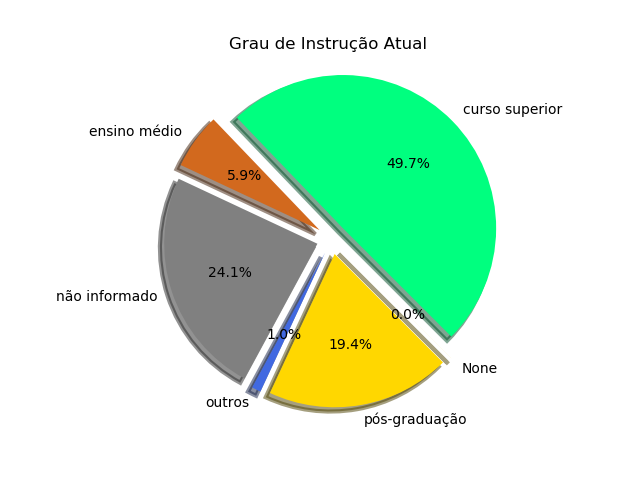

In [39]:
# pizza highesteducationlevelcodedescription
rotulos = instrucao['instrucao'].tolist()
quantidades = instrucao['quantidade'].tolist()
explode = [.1] * len(instrucao)  

fig, ax = plt.subplots()
ax.pie(quantidades, explode=explode, labels=rotulos, autopct='%1.1f%%',
        shadow=True, startangle=-45, wedgeprops={'linewidth': 3}, colors=['gold', 'springgreen', 'chocolate', 'grey',  'royalblue'])
ax.set_title(u'Grau de Instrução Atual')
ax.axis('equal')

plt.show();

In [40]:
anos = spark.sql("""
    select cast(totalexperienceyears as integer) as anos
    from tab_outros
    where totalexperienceyears is not null
      and cast(totalexperienceyears as integer) < 50
""").toPandas()['anos'].tolist()

<IPython.core.display.Javascript object>


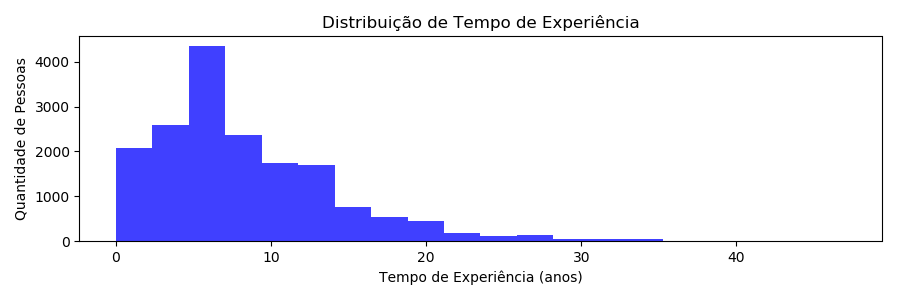

In [41]:
# histograma totalexperienceyears
fig, ax = plt.subplots(figsize=(9, 3))

ax.hist(anos, 20, histtype='stepfilled', facecolor='b', alpha=0.75)
ax.set_title(u'Distribuição de Tempo de Experiência')
ax.set_xlabel(u'Tempo de Experiência (anos)')
ax.set_ylabel(u'Quantidade de Pessoas')

fig.tight_layout()
plt.show();

In [42]:
soft = spark.read.format('csv') \
    .option('sep', '|') \
    .option('header', 'True') \
    .load(caminho + '02_soft.csv')
soft.createOrReplaceTempView("tab_soft")

In [43]:
soft.toPandas()

,SoftSkillName,id
0,habilidade na liderança de equipes,cv12714.xml
1,multidisciplinares para atuação em projetos de...,cv12714.xml
2,experiência em gerenciamento,cv12714.xml
3,levantamento de requisitos,cv12714.xml
4,Facilidade com análise,cv12714.xml
5,organizada,cv12714.xml
6,disciplinada,cv12714.xml
7,proativa,cv12714.xml
8,Gosto de trabalhar em equipe,cv12714.xml
9,Habilidades no relacionamento interpessoal,cv24026.xml


In [44]:
soft.describe().toPandas()

,summary,SoftSkillName,id
0,count,17543,33121
1,mean,None,None
2,stddev,None,None
3,min,*,cv10001.xml
4,max,; Trabalho em equipe,cv9996.xml


In [45]:
# quantidade de softskillname distintas
spark.sql("""
    select count(*) 
    from (
            select distinct softskillname
            from tab_soft
         )
""").collect()[0][0]

6337